In [1]:
import meep as mp
from meep import mpb
import numpy as np
from meep import mpb
from matplotlib import pyplot as plt
from IPython.display import Video
from meep.materials import Si

Using MPI version 3.1, 1 processes


In [2]:
lambda_0 = 6.67
max_eps = 2.9
min_eps = 2.5
dP    = 0.5     # negative for negative chirp
L     = 400    # Length of grating in microns
simulation_time = 1000

In [3]:
period0 = lambda_0 / (2 * np.sqrt((max_eps + min_eps) / 2))

# generate effective periods
P1 = period0-dP/2
P2 = period0+dP/2

# Find a proper length so we can end on a maxima
from scipy import optimize
f = lambda L_iter: np.abs(((1/P2 - 1/P1) / 2 + 1/P1)*L_iter - np.round(((1/P2 - 1/P1) / 2 + 1/P1)*L_iter))**2 
root = optimize.newton(f, L)
L=root

In [4]:
resolution = 20

dpml = 4
pml_layers = [mp.PML(thickness=dpml)]

sz = L+2 + 10 *dpml
cell_size = mp.Vector3(z=sz)

In [5]:
v0 = 0.15  # pulse center frequency
a = 0.2*v0   # Gaussian envelope half-width
b = 0.1  # linear chirp rate (positive: up-chirp, negative: down-chirp)
t0 = 15   # peak time

chirp = lambda t: np.exp(1j*2*np.pi*v0*(t-t0)) * np.exp(-a*(t-t0)**2+1j*b*(t-t0)**2)

kx = 0.4    # initial guess for wavevector in x-direction of eigenmode
kpoint = mp.Vector3(kx)
bnum = 1

# mp.CustomSource(src_func=chirp,center_frequency=v0)
src_pt = mp.Vector3(z=-0.5*sz + dpml + 2)
sources = [mp.Source(src=mp.CustomSource(src_func=chirp,center_frequency=v0),
                    center=src_pt,
                    component=mp.Ex
                    )]

In [6]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    resolution=resolution,
                    sources=sources,
                    default_material=mp.Medium(epsilon=min_eps))

nf = 1000
df = 0.2*v0


mon_pt_1 = mp.Vector3(z=-0.5*sz+dpml+4)
flux_1 = sim.add_flux(v0,df,nf,mp.FluxRegion(center=mon_pt_1,size=mp.Vector3()))

mon_pt_2 = mp.Vector3(z=0.5*sz-dpml-4)
flux_2 = sim.add_flux(v0,df,nf,mp.FluxRegion(center=mon_pt_2,size=mp.Vector3()))
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000600806 s
Working in 3D dimensions.
Computational cell is 0.05 x 0.05 x 441.75 with resolution 20
time for set_epsilon = 0.105923 s
-----------


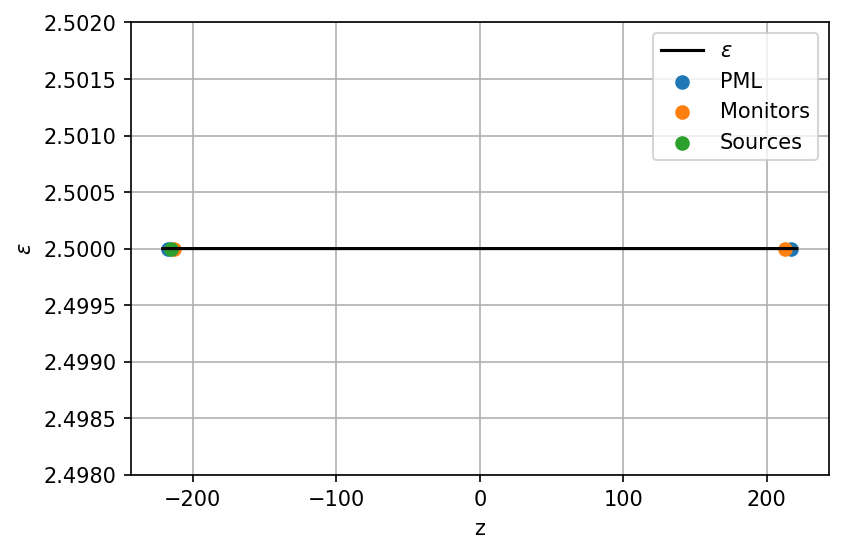

In [7]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Dielectric)
z = np.linspace(-sz/2,sz/2,eps_data.size)
plt.figure(dpi=150)
plt.plot(z,eps_data,'k',label='$\epsilon$')
plt.scatter([-sz/2+dpml,sz/2-dpml],[min_eps,min_eps],label='PML')
plt.scatter([mon_pt_1.z,mon_pt_2.z],[min_eps,min_eps],label='Monitors')
plt.scatter([src_pt.z],[min_eps],label='Sources')
plt.legend()
plt.grid(True)
plt.xlabel('z')
plt.ylabel('$\epsilon$')
plt.show()

In [8]:
sim.run(until=simulation_time)

Meep progress: 28.75/1000.0 = 2.9% done in 4.0s, 135.2s to go
on time step 1150 (time=28.75), 0.00348019 s/step
Meep progress: 60.625/1000.0 = 6.1% done in 8.0s, 124.0s to go
on time step 2426 (time=60.65), 0.00313679 s/step
Meep progress: 94.375/1000.0 = 9.4% done in 12.0s, 115.2s to go
on time step 3777 (time=94.425), 0.00296273 s/step
Meep progress: 125.97500000000001/1000.0 = 12.6% done in 16.0s, 111.0s to go
on time step 5041 (time=126.025), 0.00316459 s/step
Meep progress: 158.22500000000002/1000.0 = 15.8% done in 20.0s, 106.4s to go
on time step 6331 (time=158.275), 0.00310149 s/step
Meep progress: 193.82500000000002/1000.0 = 19.4% done in 24.0s, 99.8s to go
on time step 7756 (time=193.9), 0.00280793 s/step
Meep progress: 228.35000000000002/1000.0 = 22.8% done in 28.0s, 94.6s to go
on time step 9137 (time=228.425), 0.00289756 s/step
Meep progress: 261.8/1000.0 = 26.2% done in 32.0s, 90.3s to go
on time step 10475 (time=261.875), 0.00298983 s/step
Meep progress: 296.0250000000000

In [9]:
incident_flux_1 = mp.get_fluxes(flux_1)
incident_flux_data_1 = sim.get_flux_data(flux_1)
incident_flux_2 = mp.get_fluxes(flux_2)
incident_flux_data_2 = sim.get_flux_data(flux_2)

In [10]:
# generate grating chirping profile
def epsilon_func(V):
    x = V.z
    beta = (1/P2 - 1/P1) / L
    phase = 2 * np.pi * (1/P1 * (x+L/2) + 0.5 * beta * (x+L/2) * (x+L/2))
    chirp = 0.5*(max_eps-min_eps)*(np.cos(phase-np.pi)) + 0.5*(max_eps+min_eps)
    return chirp
geometry = [mp.Block(center=mp.Vector3(),size=mp.Vector3(mp.inf,mp.inf,L), epsilon_func=epsilon_func)]

In [11]:
sim.reset_meep()
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    resolution=resolution,
                    sources=sources,
                    geometry=geometry,
                    default_material=mp.Medium(epsilon=min_eps))

flux_1 = sim.add_flux(v0,df,nf,mp.FluxRegion(center=mon_pt_1,size=mp.Vector3()))
flux_2 = sim.add_flux(v0,df,nf,mp.FluxRegion(center=mon_pt_2,size=mp.Vector3()))
sim.load_minus_flux_data(flux_1,incident_flux_data_1)
#sim.load_minus_flux_data(flux_2,incident_flux_data_2)
sim.init_sim()


Field time usage:
        connecting chunks: 0.498813 s
            time stepping: 10.5444 s
            communicating: 37.6416 s
        outputting fields: 0.000758266 s
     Fourier transforming: 71.7351 s
          everything else: 2.71037 s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000915668 s
Working in 3D dimensions.
Computational cell is 0.05 x 0.05 x 441.75 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,399.764)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 1.84161 s
-----------


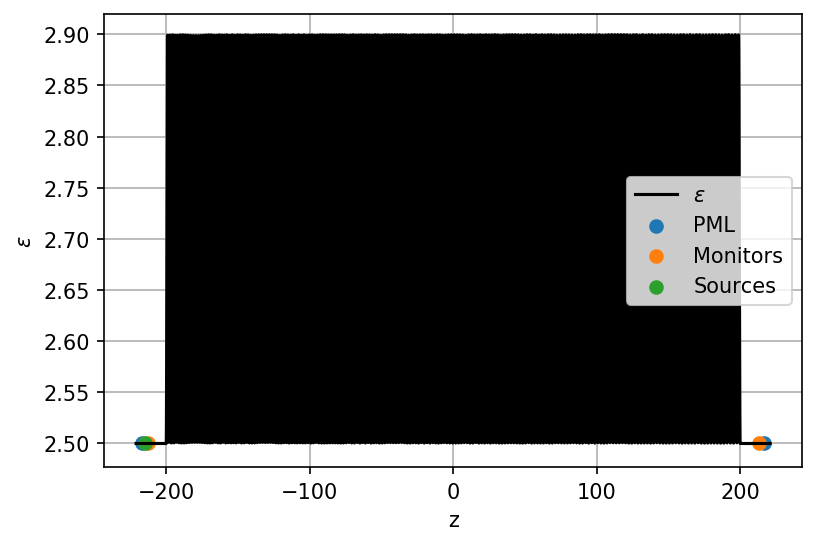

In [12]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Dielectric)
z = np.linspace(-sz/2,sz/2,eps_data.size)
plt.figure(dpi=150)
plt.plot(z,eps_data,'k',label='$\epsilon$')
plt.scatter([-sz/2+dpml,sz/2-dpml],[min_eps,min_eps],label='PML')
plt.scatter([mon_pt_1.z,mon_pt_2.z],[min_eps,min_eps],label='Monitors')
plt.scatter([src_pt.z],[min_eps],label='Sources')
plt.legend()
plt.grid(True)
plt.xlabel('z')
plt.ylabel('$\epsilon$')
plt.show()

In [13]:
fields = []
vol = mp.Volume(center=mp.Vector3(),size=mp.Vector3(z=sz))
def save_fields(sim, todo):
    if todo == 'step':
        fields.append(sim.get_array(vol=vol,component=mp.Ex))

In [14]:
sim.run(mp.at_every(1,save_fields),until=simulation_time)

Meep progress: 24.450000000000003/1000.0 = 2.4% done in 4.0s, 159.7s to go
on time step 978 (time=24.45), 0.0040921 s/step
Meep progress: 57.725/1000.0 = 5.8% done in 8.0s, 130.7s to go
on time step 2309 (time=57.725), 0.00300677 s/step
Meep progress: 91.75/1000.0 = 9.2% done in 12.0s, 118.8s to go
on time step 3671 (time=91.775), 0.00293836 s/step
Meep progress: 124.825/1000.0 = 12.5% done in 16.0s, 112.2s to go
on time step 4994 (time=124.85), 0.003024 s/step
Meep progress: 159.525/1000.0 = 16.0% done in 20.0s, 105.4s to go
on time step 6382 (time=159.55), 0.00288211 s/step
Meep progress: 194.20000000000002/1000.0 = 19.4% done in 24.0s, 99.6s to go
on time step 7769 (time=194.225), 0.00288409 s/step
Meep progress: 228.9/1000.0 = 22.9% done in 28.0s, 94.4s to go
on time step 9158 (time=228.95), 0.00288066 s/step
Meep progress: 263.575/1000.0 = 26.4% done in 32.0s, 89.4s to go
on time step 10546 (time=263.65), 0.00288344 s/step
Meep progress: 297.975/1000.0 = 29.8% done in 36.0s, 84.9s

In [15]:
reflection_flux = mp.get_fluxes(flux_1)
transmission_flux = mp.get_fluxes(flux_2)

In [16]:
reflection = -np.array(reflection_flux) / np.array(incident_flux_1)
transmission = np.array(transmission_flux) / np.array(incident_flux_2)
freqs = np.array(mp.get_flux_freqs(flux_1))

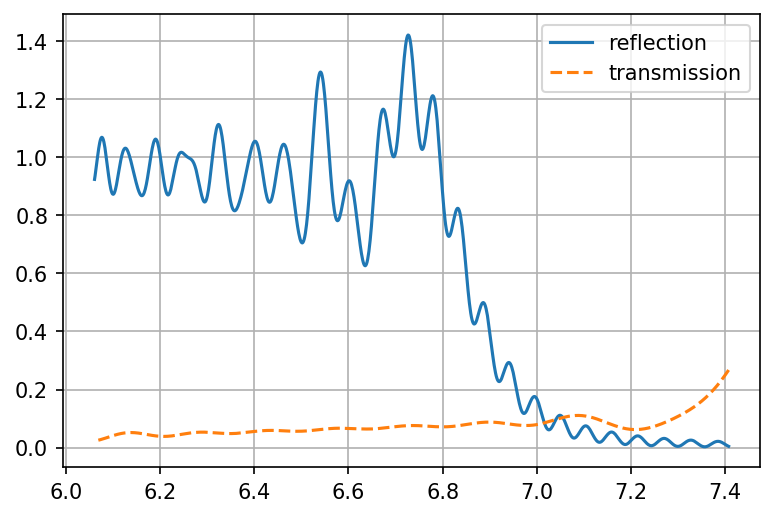

In [17]:
plt.figure(dpi=150)
plt.plot(1/freqs,reflection,label='reflection')
plt.plot(1/freqs,transmission, '--', label='transmission')
plt.grid(True)

plt.legend()
plt.show()

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [3.39623866e-250 1.97417184e-243 2.78232604e-237 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [2.63088017e-016 2.59170691e-015 8.56689234e-015 ... 4.03588677e-017
  1.16076373e-017 1.14727164e-018]
 [7.95259567e-018 1.13358957e-016 6.56716306e-016 ... 1.38924002e-018
  5.92500812e-019 7.04406568e-020]
 [3.03754557e-016 3.22215737e-015 1.21974447e-014 ... 2.04495045e-017
  5.14514833e-018 4.71181322e-019]]


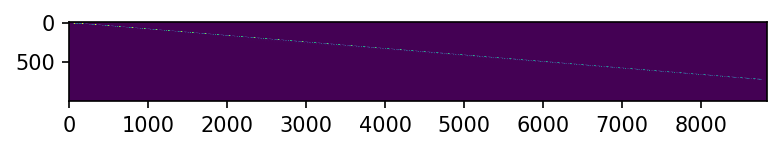

In [18]:
temp = np.array(np.abs(fields)**2) / max(np.array(np.abs(fields)**2).flatten())
print(temp)
plt.figure(dpi = 150)
plt.imshow((temp))
plt.show()

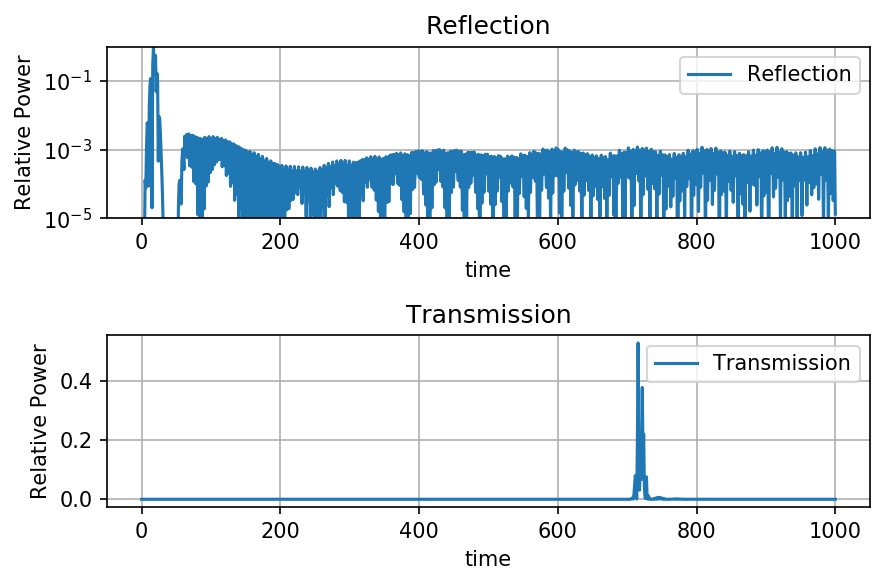

In [23]:
z_pt_mon1 = np.argmin(np.abs(z-mon_pt_1.z)**2)
z_pt_mon2 = np.argmin(np.abs(z-mon_pt_2.z)**2)

plt.figure(dpi=150)
t = np.linspace(0,simulation_time,temp.shape[0])

plt.subplot(2,1,1)
plt.title('Reflection')
plt.semilogy(t,temp[:,z_pt_mon1],label='Reflection')
#plt.plot(t,temp[:,z_pt_mon2],label='Transmission')
plt.legend()
plt.xlabel('time')
plt.ylabel('Relative Power')
plt.grid(True)
plt.ylim(1e-5,1)

plt.subplot(2,1,2)
plt.title('Transmission')
plt.plot(t,temp[:,z_pt_mon2],label='Transmission')
plt.legend()
plt.xlabel('time')
plt.ylabel('Relative Power')
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
'''from matplotlib import animation

fig, ax = plt.subplots(dpi=150)
xdata, ydata = z[:-1], temp[0,:]
ln, = plt.plot(xdata, ydata, 'r')
plt.ylim(0,1)

def update(frame):
    xdata, ydata = z[:-1], temp[frame,:]
    ln.set_data(xdata, ydata)
    return ln,

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

ani = animation.FuncAnimation(fig, update, frames=range(0,len(fields)), blit=False)
ani.save('media/chirp_time.mp4', writer=writer)
plt.close()'''

"from matplotlib import animation\n\nfig, ax = plt.subplots(dpi=150)\nxdata, ydata = z[:-1], temp[0,:]\nln, = plt.plot(xdata, ydata, 'r')\nplt.ylim(0,1)\n\ndef update(frame):\n    xdata, ydata = z[:-1], temp[frame,:]\n    ln.set_data(xdata, ydata)\n    return ln,\n\n# Set up formatting for the movie files\nWriter = animation.writers['ffmpeg']\nwriter = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)\n\nani = animation.FuncAnimation(fig, update, frames=range(0,len(fields)), blit=False)\nani.save('media/chirp_time.mp4', writer=writer)\nplt.close()"

In [21]:
'''Video('media/chirp_time.mp4')'''

"Video('media/chirp_time.mp4')"